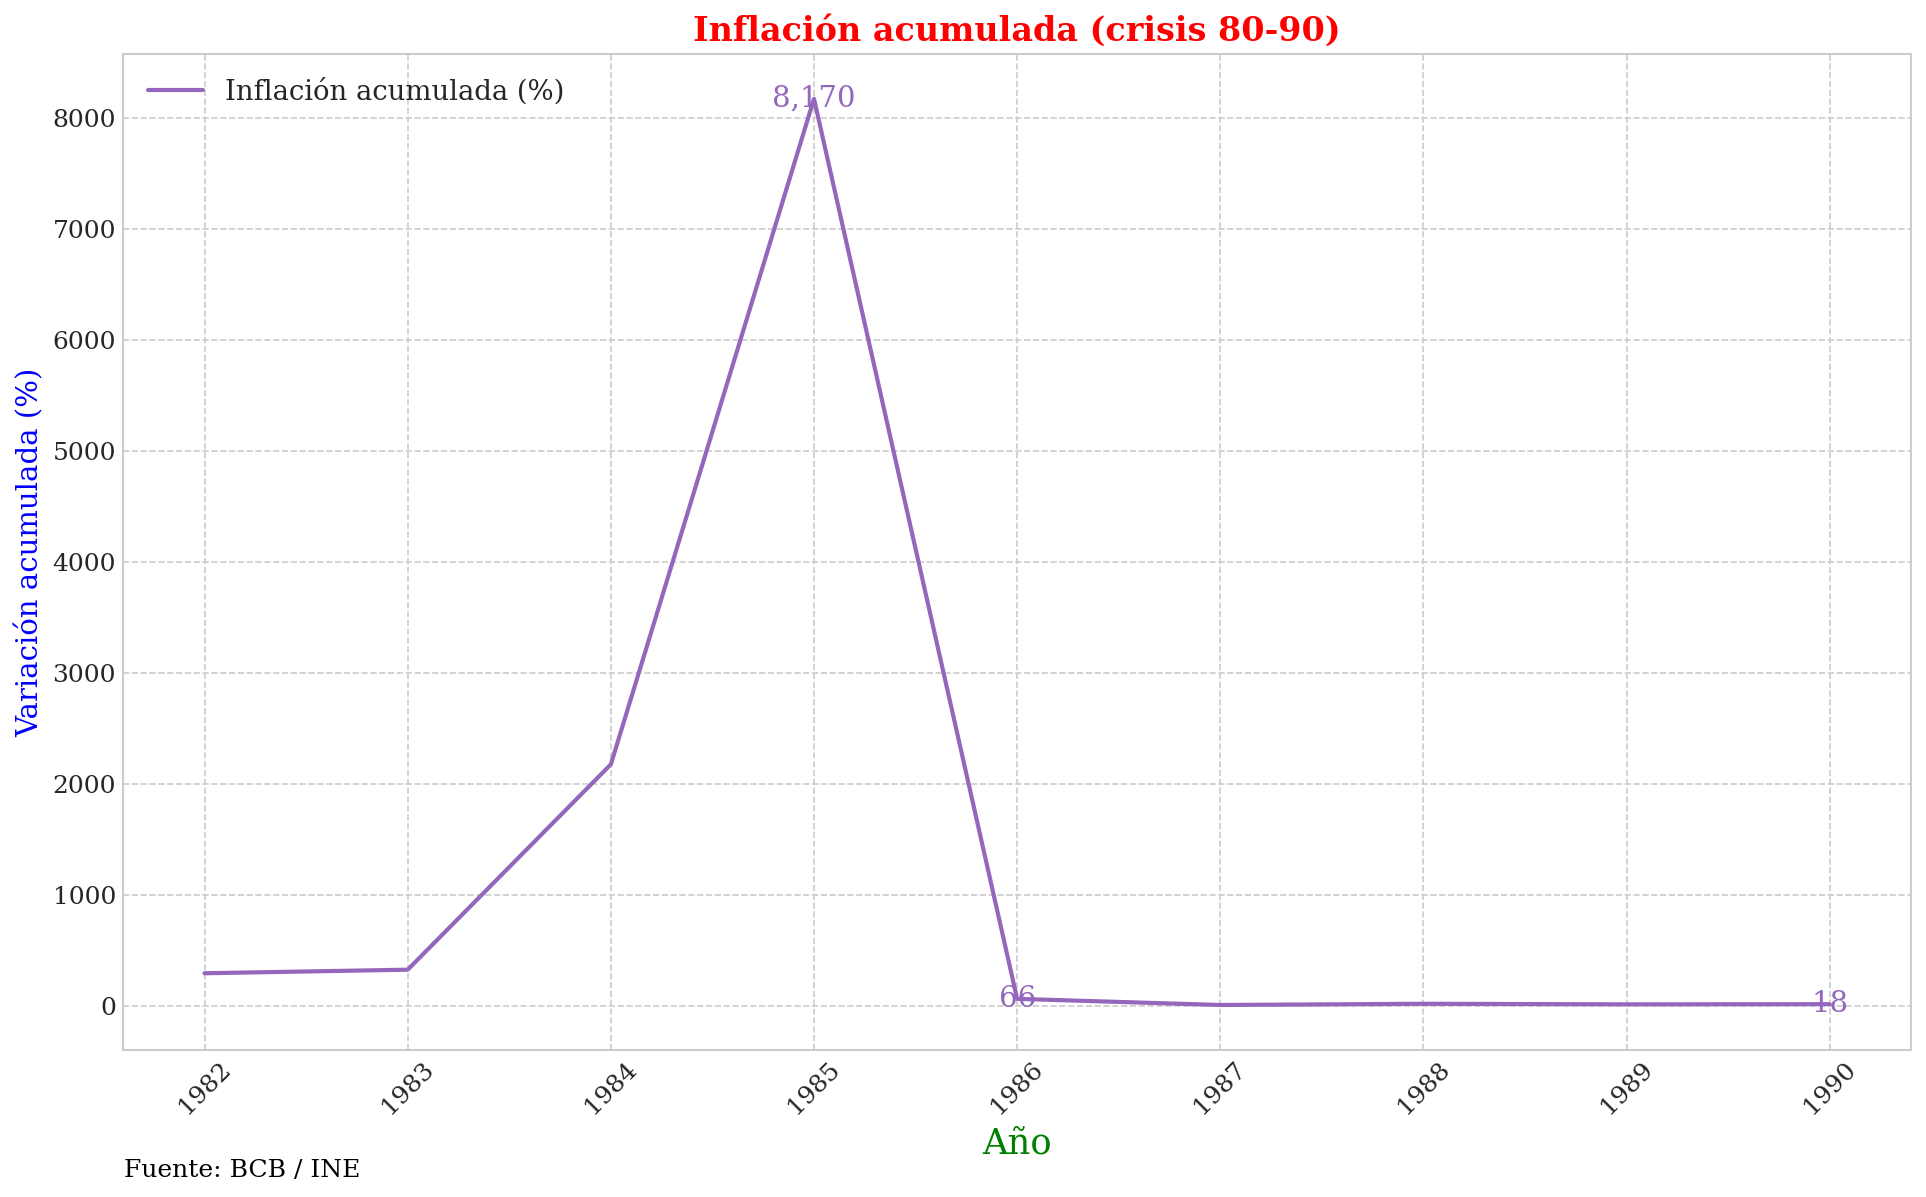

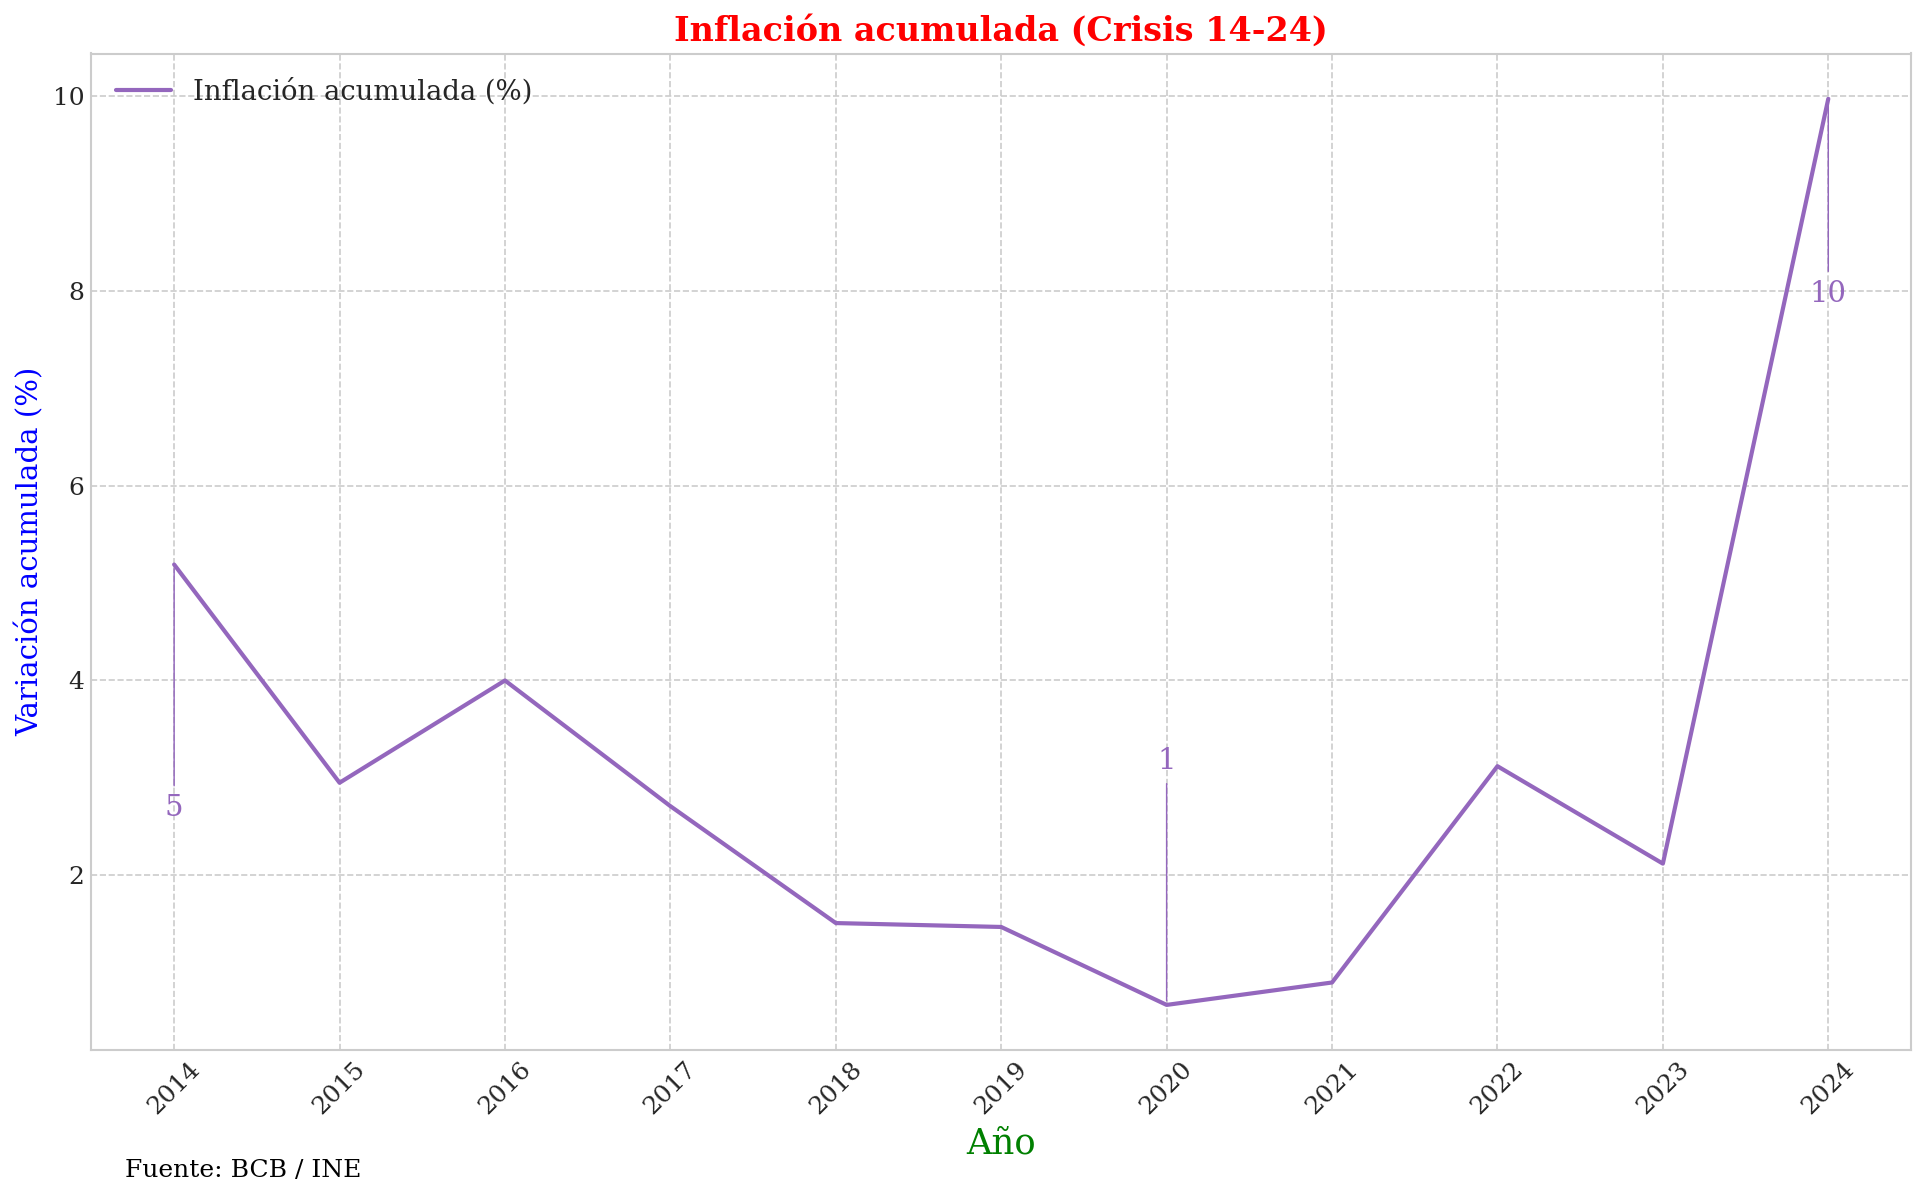

In [6]:
# ─────────────────────────────────────────────────────────────────────
# Importaciones
# ─────────────────────────────────────────────────────────────────────
import sys, os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Si aún no instalaste el paquete en editable, descomenta:
# sys.path.append(os.path.abspath('../'))

from func_auxiliares.graficos_utils import (
    get_df, set_style, init_base_plot,
    add_year_value_annotations, compute_annot_years
)
from func_auxiliares.config import (
    DB_PATH, ASSETS_DIR, PERIODOS_PARA_CRISIS
)

# ─────────────────────────────────────────────────────────────────────
# Configuración general
# ─────────────────────────────────────────────────────────────────────
output_dir = ASSETS_DIR / "crisis" / "inflacion_acumulada"
output_dir.mkdir(parents=True, exist_ok=True)

set_style()

# ─────────────────────────────────────────────────────────────────────
# Carga de datos
# ─────────────────────────────────────────────────────────────────────
SQL = """
    SELECT
      año,
      inflacion
    FROM inflacion_acumulada
"""
df = get_df(SQL, str(DB_PATH), index_col="año")

# ─────────────────────────────────────────────────────────────────────
# Componentes y parámetros de graficado
# ─────────────────────────────────────────────────────────────────────
componentes      = [("inflacion", "Inflación acumulada (%)")]
cols_componentes = [col for col, _ in componentes]
colors           = {"inflacion": "#9467bd"}

# ─────────────────────────────────────────────────────────────────────
# Offsets y años extra para anotaciones
# ─────────────────────────────────────────────────────────────────────
# Define desplazamientos (x_offset, y_offset) para cada año posible
annotation_offsets = {
    "inflacion": {
        1950: (0, -2.0),
        1956: (0,  2.0),
        1960: (0, -1.8),
        1980: (0,  1.8),
        1985: (0, -2.2),
        1986: (0, -2.2),
        1990: (0,  2.2),
        2014: (0, -2.5),
        2020: (0,  2.5),
        2024: (0, -2.0),
    }
}

# Años extra por subperíodo, además del primero y último
extra_annots = {
    "Crisis 50-60": [1956],
    "crisis 80-90": [1985,1986],
    "Crisis 14-24": [2020],
}

# ─────────────────────────────────────────────────────────────────────
# Generación de gráficas por subperíodo de crisis
# ─────────────────────────────────────────────────────────────────────
for nombre, (ini, fin) in PERIODOS_PARA_CRISIS.items():
    # Recorta al rango disponible en df
    sub = df.loc[ini:fin]
    if sub.empty:
        continue  # salta si no hay datos en ese rango

    # Calcula años a anotar: siempre ini/fin + extras dentro del rango
    years_to_annot = compute_annot_years(ini, fin, extra_annots.get(nombre))

    fig, ax = init_base_plot(
        sub,
        series=componentes,
        colors=colors,
        title=f"Inflación acumulada ({nombre})",
        xlabel="Año",
        ylabel="Variación acumulada (%)",
        source_text="Fuente: BCB / INE"
    )

    add_year_value_annotations(
        ax,
        sub,
        years_to_annot,
        cols_componentes,
        annotation_offsets,
        colors,
        arrow_lw=0.7
    )

    fig.savefig(output_dir / f"inflacion_acumulada_{nombre}.png")
    plt.show()  # Muestra la gráfica en pantalla
    plt.close(fig)

